In [40]:
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from tqdm import tqdm
import emcee

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from schwimmbad import MultiPool

from coordinates import (pal5_c, galcen_frame, 
                         pal5_lead_frame, pal5_trail_frame)

from density_1d import run_it_all


### Added by SP
# This project:
from gala.units import galactic

from potential import default_mw
from coordinates import (pal5_c, galcen_frame,
                         pal5_lead_frame, pal5_trail_frame)

from potential import get_bar_model
from coordinates import pal5_M

Grab coordinates of M5, and remove stars close to M5 or the Pal 5 cluster:

In [41]:
# m5_c = coord.SkyCoord.from_name('Messier 5')
m5_c = coord.SkyCoord('15 18 33.22', '+02 04 51.7', 
                      unit=(u.hourangle, u.degree))

## Loead in data

In [42]:
ana = fits.getdata('../data/pal5_ls_lite_grz.fits')
ana_masks = fits.getdata('../data/cmd_masks_orig.fits')
ana = ana[ana_masks['gr_mask'] & ana_masks['grz_mask']]

data_c = coord.SkyCoord(ra=ana['ra'], dec=ana['dec'], unit=u.deg)
pal5_m5_mask = (data_c.separation(pal5_c) > 0.2*u.deg) & (data_c.separation(m5_c) > 0.3*u.deg)
data_c = data_c[pal5_m5_mask]

Load Ana's spatial mask around the deeper footprint:

In [43]:
mask_zlim = 23.7
mask_pts = np.load('../data/concave_hull_z{:.1f}.npz'.format(mask_zlim))['pts']
path_concavehull = mpl.path.Path(mask_pts)

_c = data_c.transform_to(gc.Pal5)
_X = np.stack((_c.phi1.degree, _c.phi2.degree)).T
deep_mask = path_concavehull.contains_points(_X)

## SP ran sims in this notebook to check odd results

In [44]:
mw = default_mw

pot_flat = gp.CCompositePotential()
pot_flat['halo'] = gp.NFWPotential(m = mw['halo'].parameters['m'],
                                  r_s = mw['halo'].parameters['r_s'],
                                  c = 0.5, units=galactic)
pot_flat['disk'] = mw['disk']
pot_flat['bulge'] = mw['bulge']

pot_reg = mw
pal5_M


<Quantity 14404. solMass>

In [45]:
w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)

release_every=1 
n_particles=1
dt=-0.5 
n_steps=6000
    
df = gd.FardalStreamDF(random_state=np.random.RandomState(42))

H = gp.Hamiltonian(pot_flat)
prog_pot = gp.PlummerPotential(pal5_M, 4*u.pc, units=galactic)
gen = gd.MockStreamGenerator(df = df, hamiltonian = H,
                                 progenitor_potential = prog_pot)

stream_data, _ = gen.run(w0, pal5_M,
                             dt=dt, n_steps=n_steps,
                             release_every=release_every,
                             n_particles=n_particles)

#cache_file = 'chaotic_orb.hdf5'
# if path.exists(cache_file):
#     os.unlink(cache_file)
sim_c_flat = stream_data.to_coord_frame(gc.Pal5PriceWhelan18,
                                       galactocentric_frame=galcen_frame)

#f = stream_data.to_hdf5('chaotic_orb.hdf5')
#f.close()

In [46]:
##regular orbit  

H_reg = gp.Hamiltonian(pot_reg)
prog_pot = gp.PlummerPotential(pal5_M, 4*u.pc, units=galactic)
gen_reg = gd.MockStreamGenerator(df = df, hamiltonian = H_reg,
                                 progenitor_potential = prog_pot)

stream_data_reg, _ = gen_reg.run(w0, pal5_M,
                             dt=dt, n_steps=n_steps,
                             release_every=release_every,
                             n_particles=n_particles)



sim_c_reg = stream_data_reg.to_coord_frame(gc.Pal5PriceWhelan18,
                                       galactocentric_frame=galcen_frame)

#f = stream_data_reg.to_hdf5('reg_orb.hdf5')
#f.close()

## Load in sims

In [47]:
##Read in bar models

# There's something wring with my hdf5 files for the non-barred models. 
#chaotic = gd.PhaseSpacePosition.from_hdf5('chaotic_orb.hdf5')
#reg = gd.PhaseSpacePosition.from_hdf5('reg_orb.hdf5')

reg = stream_data_reg
chaotic = stream_data

bar5e9 = gd.PhaseSpacePosition.from_hdf5('BarModels_RL1_Mb5e+09_Om38.0.hdf5')
bar1e10 = gd.PhaseSpacePosition.from_hdf5('BarModels_RL1_Mb1e+10_Om45.0.hdf5')


In [48]:
#sim_c_reg

In [49]:
#bar5e9_c= bar5e9.to_coord_frame(gc.Pal5PriceWhelan18,
 #                                      galactocentric_frame=galcen_frame)
#bar1e10_c= bar1e10.to_coord_frame(gc.Pal5PriceWhelan18,
 #                                      galactocentric_frame=galcen_frame)

    #reg_c = reg.to_coord_frame(coord.ICRS,
reg_c = reg.to_coord_frame(gc.Pal5PriceWhelan18,
                                      galactocentric_frame=galcen_frame)

chaotic_c = chaotic.to_coord_frame(gc.Pal5PriceWhelan18,
                                       galactocentric_frame=galcen_frame)

bar5e9_c = bar5e9.to_coord_frame(gc.Pal5PriceWhelan18,
                                       galactocentric_frame=galcen_frame)
bar1e10_c = bar1e10.to_coord_frame(gc.Pal5PriceWhelan18,
                                       galactocentric_frame=galcen_frame)    

In [50]:
sim_c_bar5e9 = bar5e9.to_coord_frame(gc.Pal5PriceWhelan18, galactocentric_frame=galcen_frame)
sim_c_bar1e10 = bar1e10.to_coord_frame(gc.Pal5PriceWhelan18, galactocentric_frame=galcen_frame)

Text(0,0.5,'$\\phi_2$[deg]')

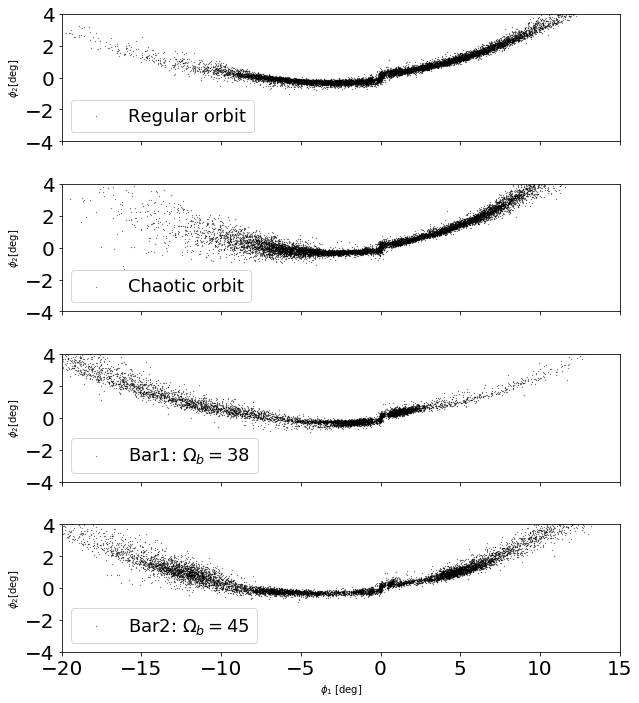

In [51]:

fig,axes = plt.subplots(4,1,figsize=(10,12), sharex=True, sharey = True)

mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 18#label_size 
mpl.rcParams['ytick.labelsize'] =18 #label_size 

axes[0].scatter(sim_c_reg.phi1, sim_c_reg.phi2,s=0.05,color='black', label='Regular orbit', rasterized=True)
axes[0].set_xlim(-20,15)
axes[0].set_ylim(-4,4)
axes[0].set_aspect('equal')
#axes[0,0].set_xlabel('$\phi_1$ [deg]')
axes[0].set_ylabel('$\phi_2$[deg]')
axes[0].legend(loc='lower left', fontsize=18)
#axes[1,0].set_title('Regular orbit') #make sure I grab correct Om. 

axes[1].scatter(sim_c_flat.phi1, sim_c_flat.phi2,s=0.05,color='black', label='Chaotic orbit', rasterized=True)
axes[1].set_xlim(-20,15)
axes[1].set_ylim(-4,4)
axes[1].set_yticks([-4,-2,0,2,4])
axes[1].set_aspect('equal')
axes[1].legend(loc='lower left', fontsize=18)
#axes[0,1].set_xlabel('$\phi_1$ [deg]')
axes[1].set_ylabel('$\phi_2$[deg]')
#axes[1,1].set_title('Chaotic orbit') #make sure I grab correct Om. 


axes[2].scatter(sim_c_bar5e9.phi1, sim_c_bar5e9.phi2,s=0.05, color='black', label='Bar1: $\Omega_b = 38$', rasterized=True)
axes[2].set_xlim(-20,15)
axes[2].set_ylim(-4,4)
axes[2].set_aspect('equal')
#axes[2].set_xlabel('$\phi_1$ [deg]')
axes[2].set_ylabel('$\phi_2$[deg]')
axes[2].legend(loc='lower left', fontsize=18)
#axes[1,0].set_title('Regular orbit') #make sure I grab correct Om. 

axes[3].scatter(sim_c_bar1e10.phi1, sim_c_bar1e10.phi2,s=0.05, color='black', label='Bar2: $\Omega_b = 45$',rasterized=True)
axes[3].set_xlim(-20,15)
axes[3].set_ylim(-4,4)
axes[3].set_aspect('equal')
axes[3].set_xlabel('$\phi_1$ [deg]')
axes[3].legend(loc='lower left', fontsize=18)
axes[3].set_ylabel('$\phi_2$[deg]')
#axes[1,1].set_title('Chaotic orbit') #make sure I grab correct Om. 
    
#fig.tight_layout()
#fig.savefig('/Users/spearson/Dropbox/AnaPal5/Fig4_Sims.pdf',dpi=200, rastorized=True)
#fig.savefig('/Users/spearson/Desktop/Pal5sBiggestFan/paper/Fig4_Sims.pdf',dpi=200, rastorized=True)

In [52]:
# ###Testing that hdf5's look normal

# plt.scatter(reg_c.ra, reg_c.dec, s=0.01)
# plt.xlim(250,215)
# plt.ylim(-10,10)

# plt.scatter(chaotic_c.ra, chaotic_c.dec, s=0.01)
# plt.xlim(250,215)
# plt.ylim(-10,10)


In [53]:
sims = [ reg_c, chaotic_c, bar5e9_c, bar1e10_c]

(-20, 20)

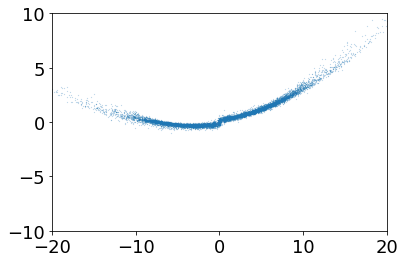

In [54]:
# ###Testing that hdf5's look normal

plt.scatter(reg_c.phi1, reg_c.phi2, s=0.01)
#plt.xlim(250,215)
#plt.ylim(-5,5)
#plt.ylim(-5,5)

# plt.scatter(chaotic_c.ra, chaotic_c.dec, s=0.01)
# plt.xlim(250,215)
plt.ylim(-10,10)
plt.xlim(-20,20)

In [55]:
tbls_sims = []
for i in range(len(sims)): 
    print(i)
    with MultiPool() as pool:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tbls_s = run_it_all(sims[i], 'sim' + str(i), pool=pool)#, overwrite=True)
            tbls_sims.append(tbls_s)

0


  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'lead'


  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'trail'


100%|██████████| 26/26 [00:00<00:00, 195.45it/s]


1


  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'lead'


  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'trail'


100%|██████████| 26/26 [00:00<00:00, 210.32it/s]


2


  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'lead'


  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'trail'


100%|██████████| 26/26 [00:00<00:00, 234.75it/s]

3



  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'lead'


  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'trail'


100%|██████████| 26/26 [00:00<00:00, 200.89it/s]


In [56]:
#tbls_sims[0][lead]

In [57]:
# #tbls_sims
# fig = plt.figure(figsize=(6, 6))

# for i in range(len(tbls_sims)):
#     for name in tbls.keys():
#         print(name)
#         tbl = tbls_sims[i][name]
#         med = np.median(tbl['std_s'], axis=1)
#         err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
#         err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
#         plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
#                  ls='none', marker='o', label=name)
#     plt.legend(loc='best', fontsize=15)
    
# plt.xlim(0, 17)
# plt.xticks(np.arange(0, 16+1e-3, 2))
# plt.ylim(0, 0.6)

# plt.xlabel(r'$\Delta \phi_1$ [deg]')
# plt.ylabel(r'$\sigma$ [deg]')
# fig.set_facecolor('w')
# fig.tight_layout()

# # fig.savefig('../plots/density-1d-width.png', dpi=250)

In [58]:
#data_c[deep_mask]

In [59]:
with MultiPool() as pool:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tbls = run_it_all(data_c[deep_mask], 'data', pool=pool)#, overwrite=True)

100%|██████████| 22/22 [00:00<00:00, 206.49it/s]

running measurements for 'lead'
running measurements for 'trail'


In [60]:
tbls.keys()

dict_keys(['lead', 'trail'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


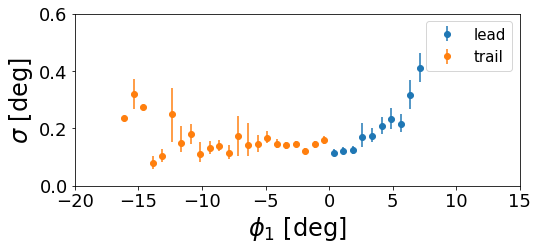

In [61]:
fig = plt.figure(figsize=(8, 4))

#for name in tbls.keys():
tbl = tbls['lead']
med = np.median(tbl['std_s'], axis=1)
err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label='lead')

tbl = tbls['trail']
med = np.median(tbl['std_s'], axis=1)
err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
plt.errorbar(-tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label='trail')

plt.legend(loc='best', fontsize=15)
    
plt.xlim(-20, 15)
plt.xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))
plt.ylim(0, 0.6)

plt.xlabel(r'$\phi_1$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()

# fig.savefig('../plots/density-1d-width.png', dpi=250)

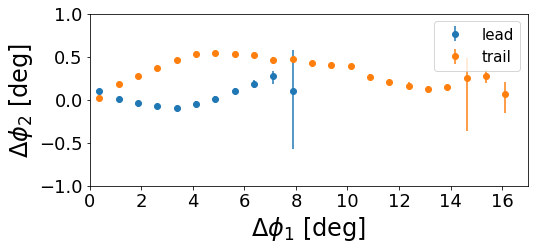

In [62]:
fig = plt.figure(figsize=(8,4))

for name in tbls.keys():
    tbl = tbls[name]
    med = np.median(tbl['mu_s'], axis=1)
    err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
    err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)
plt.legend(loc='best', fontsize=15)
    
plt.xlim(0, 17)
plt.ylim(-1, 1)
plt.xticks(np.arange(0, 16+1e-3, 2))

plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel('$\Delta \phi_2$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()

# fig.savefig('../plots/density-1d-track.png', dpi=250)

Text(0,0.5,'$f$')

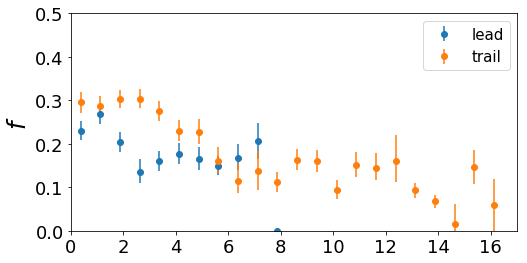

In [63]:
plt.figure(figsize=(8, 4))
for name in tbls.keys():
    tbl = tbls[name]
    med = np.median(tbl['a'], axis=1)
    err1 = med - np.percentile(tbl['a'], 16, axis=1)
    err2 = np.percentile(tbl['a'], 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)

plt.legend(loc='best', fontsize=15)

plt.xlim(0, 17)
plt.ylim(0, 0.5)
plt.xticks(np.arange(0, 16+1e-3, 2))

plt.ylabel('$f$')

# fig.savefig('../plots/density-1d-f.png', dpi=250)

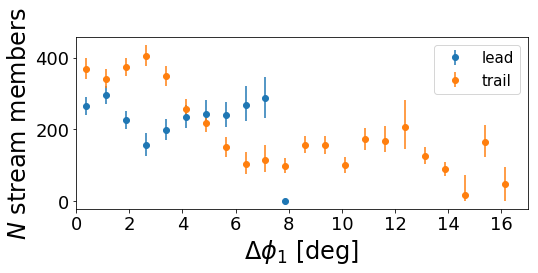

In [64]:
fig = plt.figure(figsize=(8,4))

for name in tbls.keys():
    tbl = tbls[name]
    val = tbl['a'] * tbl['N'][:, None]
    med = np.median(val, axis=1)
    err1 = med - np.percentile(val, 16, axis=1)
    err2 = np.percentile(val, 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)
    
plt.legend(loc='best', fontsize=15)
    
plt.xlim(0, 17)
# plt.ylim(0, 0.25)
plt.xticks(np.arange(0, 16+1e-3, 2))

plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel('$N$ stream members')
fig.set_facecolor('w')
fig.tight_layout()

# fig.savefig('../plots/density-1d-N.png', dpi=250)

## SP added plots of both data and sims below

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


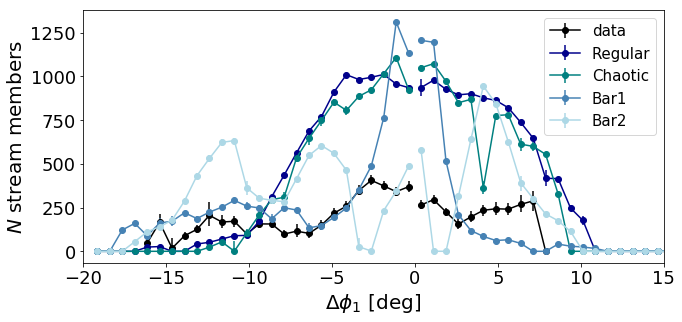

In [65]:

#### Same as above but now for sims
fig = plt.figure(figsize=(10,5))
c = ['darkblue','teal','steelblue','lightblue']
sim_name = ['Regular', 'Chaotic', 'Bar1', 'Bar2']

###DATA#####
tbl = tbls['lead']
val = tbl['a'] * tbl['N'][:, None]
med = np.median(val, axis=1)
idx_data_lead = np.where(med>50)
err1 = med - np.percentile(val, 16, axis=1)
err2 = np.percentile(val, 84, axis=1) - med
plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label='data',color='black', linestyle='-')

tbl = tbls['trail']
val = tbl['a'] * tbl['N'][:, None]
med = np.median(val, axis=1)
idx_data_trail = np.where(med>50)
err1 = med - np.percentile(val, 16, axis=1)
err2 = np.percentile(val, 84, axis=1) - med
plt.errorbar(-tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o',color='black', linestyle='-')

    
###SIMS######
idx_lead_sim = []
for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['lead']
    val = tbl['a'] * tbl['N'][:, None]
    med = np.median(val, axis=1)
    idx = np.where(med > 50)
    idx_lead_sim.append(idx)
    err1 = med - np.percentile(val, 16, axis=1)
    err2 = np.percentile(val, 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=sim_name[i], color=c[i], linestyle='-')

#ind_trail = np.zeros(len(tbls_sims))
idx_trail_sim = []
for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['trail']
    val = tbl['a'] * tbl['N'][:, None]
    med = np.median(val, axis=1)
    idx = np.where(med > 50)
    idx_trail_sim.append(idx)
    err1 = med - np.percentile(val, 16, axis=1)
    err2 = np.percentile(val, 84, axis=1) - med
    plt.errorbar(-tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', color=c[i], linestyle='-')#)#, label='trail')    
    
plt.legend(loc='best', fontsize=15)
    
plt.xlim(-20, 15)
# plt.ylim(0, 0.25)
#plt.xticks(np.arange(0, 16+1e-3, 2))
plt.xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))

plt.xlabel(r'$\Delta \phi_1$ [deg]', fontsize=20)
plt.ylabel('$N$ stream members', fontsize=20)
fig.set_facecolor('w')
fig.tight_layout()

fig.savefig('../plots/sim_data_density-1d-N.png', dpi=250)

In [66]:
idx_lead_sim

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),),
 (array([0, 1, 2, 3, 4, 5, 6, 7]),),
 (array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),)]

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


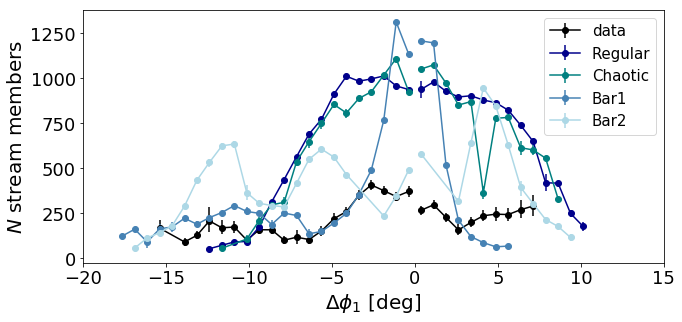

In [67]:
fig = plt.figure(figsize=(10,5))
c = ['darkblue','teal','steelblue','lightblue']
sim_name = ['Regular', 'Chaotic', 'Bar1', 'Bar2']

###DATA#####
tbl = tbls['lead']
val = tbl['a'] * tbl['N'][:, None]
med = np.median(val, axis=1)
err1 = med - np.percentile(val, 16, axis=1)
err2 = np.percentile(val, 84, axis=1) - med
plt.errorbar(tbl['phi1_c'][idx_data_lead], med[idx_data_lead], yerr=(err1[idx_data_lead], err2[idx_data_lead]),
                 ls='none', marker='o', label='data',color='black', linestyle='-')

tbl = tbls['trail']
val = tbl['a'] * tbl['N'][:, None]
med = np.median(val, axis=1)
#ind_data = np.where(med>50)
err1 = med - np.percentile(val, 16, axis=1)
err2 = np.percentile(val, 84, axis=1) - med
plt.errorbar(-tbl['phi1_c'][idx_data_trail], med[idx_data_trail], yerr=(err1[idx_data_trail], err2[idx_data_trail]),
                 ls='none', marker='o',color='black', linestyle='-')

###SIMS######
#idx_lead_sim = []
for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['lead']
    val = tbl['a'] * tbl['N'][:, None]
    med = np.median(val, axis=1)
    #idx = np.where(med > 50)
    #idx_lead_sim.append(idx)
    idx_lead_sim1 = idx_lead_sim[i]
    err1 = med - np.percentile(val, 16, axis=1)
    err2 = np.percentile(val, 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'][idx_lead_sim1], med[idx_lead_sim1], yerr=(err1[idx_lead_sim1], err2[idx_lead_sim1]),
                 ls='none', marker='o', label=sim_name[i], color=c[i], linestyle='-')

#ind_trail = np.zeros(len(tbls_sims))
#idx_trail_sim = []
for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['trail']
    val = tbl['a'] * tbl['N'][:, None]
    med = np.median(val, axis=1)
    #idx = np.where(med > 50)
    #idx_trail_sim.append(idx)
    idx_trail_sim1 = idx_trail_sim[i]
    err1 = med - np.percentile(val, 16, axis=1)
    err2 = np.percentile(val, 84, axis=1) - med
    plt.errorbar(-tbl['phi1_c'][idx_trail_sim1], med[idx_trail_sim1], yerr=(err1[idx_trail_sim1], err2[idx_trail_sim1]),
                 ls='none', marker='o', color=c[i], linestyle='-')#)#, label='trail')    
    
plt.legend(loc='best', fontsize=15)
    
plt.xlim(-20, 15)
# plt.ylim(0, 0.25)
#plt.xticks(np.arange(0, 16+1e-3, 2))
plt.xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))

plt.xlabel(r'$\Delta \phi_1$ [deg]', fontsize=20)
plt.ylabel('$N$ stream members', fontsize=20)
fig.set_facecolor('w')
fig.tight_layout()
   

In [68]:
med

array([4.88682811e+02, 3.44393073e+02, 2.33412861e+02, 1.29230739e+00,
       2.65893814e+01, 4.63717796e+02, 5.60697189e+02, 6.05188719e+02,
       5.48578060e+02, 4.15498788e+02, 2.83903470e+02, 2.91396845e+02,
       3.03934014e+02, 3.63048000e+02, 6.33545820e+02, 6.22972818e+02,
       5.31223185e+02, 4.32786782e+02, 2.88026463e+02, 1.78258174e+02,
       1.40641944e+02, 1.11191325e+02, 5.50316540e+01, 4.99073804e-02,
       4.68102902e-02, 5.20983855e-02])

## Plots for paper added by SP

In [69]:
#Only store data points with number of stream members, N > 50

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in subtract


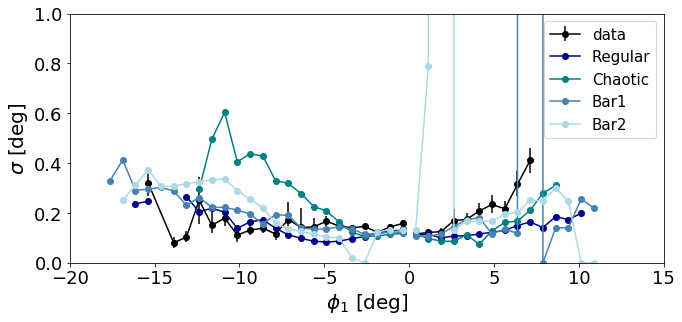

In [70]:
fig = plt.figure(figsize=(10, 5))


####FIRST plot data############
#for name in tbls.keys():
tbl = tbls['lead']
med = np.median(tbl['std_s'], axis=1)
err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
plt.errorbar(tbl['phi1_c'][idx_data_lead], med[idx_data_lead], yerr=(err1[idx_data_lead], err2[idx_data_lead]),
                 ls='none', marker='o', label='data', linestyle='-',color='black')

tbl = tbls['trail']
med = np.median(tbl['std_s'], axis=1)
err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
plt.errorbar(-tbl['phi1_c'][idx_data_trail], med[idx_data_trail], yerr=(err1[idx_data_trail], err2[idx_data_trail]),
                 ls='none', marker='o',  color='black', linestyle='-')

#plt.legend(loc='best', fontsize=15)


############Then plot sims


for i in range(len(tbls_sims)):
#for name in tbls.keys():
        #rint(name)
    tbl = tbls_sims[i]['lead']
    med = np.median(tbl['std_s'], axis=1)
    err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
    err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'], med, #yerr=(err1, err2),
                 ls='none', marker='o', label=sim_name[i], linestyle='-', color=c[i])
    

 

for i in range(len(tbls_sims)):
#for name in tbls.keys():
        #rint(name)
    tbl = tbls_sims[i]['trail']
    med = np.median(tbl['std_s'], axis=1)
    err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
    err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
    plt.errorbar(-tbl['phi1_c'], med, #yerr=(err1, err2),
                 ls='none', marker='o', linestyle='-', color=c[i])    


plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()

# fig.savefig('../plots/density-1d-width.png', dpi=250)
plt.legend(loc='best', fontsize=15)
    
plt.xlim(-20, 15)
plt.xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))
plt.ylim(0, 1.0)#0.6)

plt.xlabel(r'$\phi_1$ [deg]', fontsize=20)
plt.ylabel(r'$\sigma$ [deg]', fontsize=20)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
fig.set_facecolor('w')
fig.tight_layout()

fig.savefig('../plots/sim_data_density-1d-width.png', dpi=250)

## Track plot SP

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


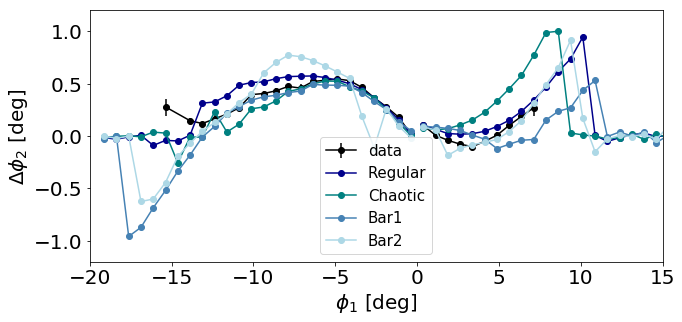

In [71]:
fig = plt.figure(figsize=(10,5))

#for name in tbls.keys():
tbl = tbls['lead']
med = np.median(tbl['mu_s'], axis=1)
err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
plt.errorbar(tbl['phi1_c'][idx_data_lead], med[idx_data_lead], yerr=(err1[idx_data_lead], err2[idx_data_lead]),
                 ls='none', marker='o', label='data', color='black', linestyle='-')

tbl = tbls['trail']
med = np.median(tbl['mu_s'], axis=1)
err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
plt.errorbar(-tbl['phi1_c'][idx_data_trail], med[idx_data_trail], yerr=(err1[idx_data_trail], err2[idx_data_trail]),
                 ls='none', marker='o', color='black', linestyle='-')#, label=name)

for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['lead']
    med = np.median(tbl['mu_s'], axis=1)
    err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
    err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'], med, #yerr=(err1, err2),
                 ls='none', marker='o', color=c[i], linestyle='-', label=sim_name[i])



for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['trail']
    med = np.median(tbl['mu_s'], axis=1)
    err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
    err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
    plt.errorbar(-tbl['phi1_c'], med, #yerr=(err1, err2),
                 ls='none', marker='o', color=c[i], linestyle='-')#, label=name)



plt.legend(loc='best', fontsize=15)
    
plt.xlim(-20, 15)
plt.xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))
plt.ylim(-1.2, 1.2)#0.6)

plt.xlabel(r'$\phi_1$ [deg]', fontsize=20)
plt.ylabel('$\Delta \phi_2$ [deg]', fontsize=20)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
fig.set_facecolor('w')
fig.tight_layout()

fig.savefig('../plots/sim_data_density-1d-track.png', dpi=250)

In [72]:
# pal5_lead = coord.SkyCoord(tbl['phi1_c']*u.deg, med*u.deg, 
#                            frame=pal5_lead_frame).transform_to(gc.Pal5)

In [73]:
#pal5_lead.phi1
#pal5_lead.phi1
#pal5_lead.phi1[idx_data_lead].value
#tbl['phi1_c'][idx_data_lead]

## Attempt at figure plot

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract


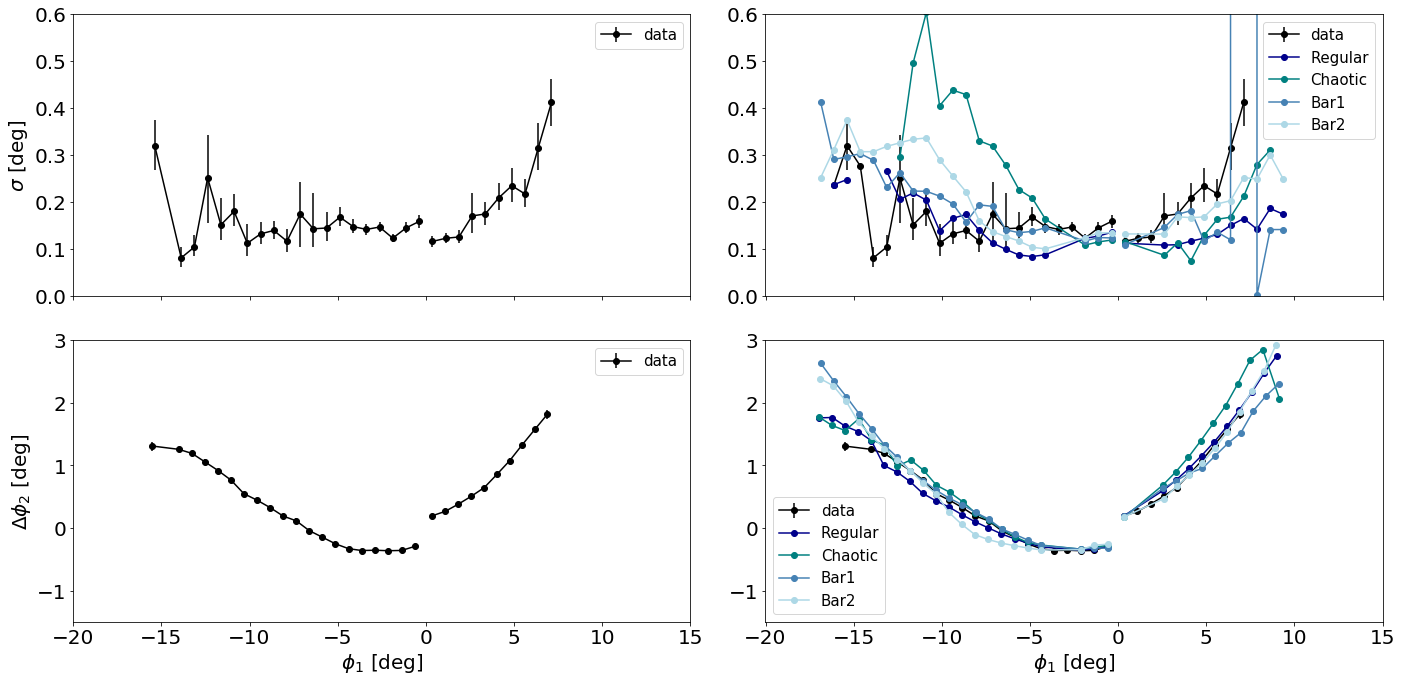

In [84]:
fig,axes = plt.subplots(2,2,figsize=(20,10),  sharex=True)


####FIRST plot data############
#for name in tbls.keys():
tbl = tbls['lead']
med = np.median(tbl['std_s'], axis=1)
err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
axes[0,0].errorbar(tbl['phi1_c'][idx_data_lead], med[idx_data_lead], yerr=(err1[idx_data_lead], err2[idx_data_lead]),
                 ls='none', marker='o', label='data', linestyle='-',color='black')

axes[0,1].errorbar(tbl['phi1_c'][idx_data_lead], med[idx_data_lead], yerr=(err1[idx_data_lead], err2[idx_data_lead]),
                 ls='none', marker='o', label='data', linestyle='-',color='black')

tbl = tbls['trail']
med = np.median(tbl['std_s'], axis=1)
err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
axes[0,0].errorbar(-tbl['phi1_c'][idx_data_trail], med[idx_data_trail], yerr=(err1[idx_data_trail], err2[idx_data_trail]),
                 ls='none', marker='o',  color='black', linestyle='-')
axes[0,1].errorbar(-tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o',  color='black', linestyle='-')

#plt.legend(loc='best', fontsize=15)


############Then plot sims


for i in range(len(tbls_sims)):
#for name in tbls.keys():
        #rint(name)
    tbl = tbls_sims[i]['lead']
    med = np.median(tbl['std_s'], axis=1)
    err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
    err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
    axes[0,1].errorbar(tbl['phi1_c'][idx_lead_sim1], med[idx_lead_sim1], #yerr=(err1, err2),
                 ls='none', marker='o', label=sim_name[i], linestyle='-', color=c[i])
    

 
for i in range(len(tbls_sims)):
#for name in tbls.keys():
        #rint(name)
    tbl = tbls_sims[i]['trail']
    med = np.median(tbl['std_s'], axis=1)
    err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
    err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
    axes[0,1].errorbar(-tbl['phi1_c'][idx_trail_sim1], med[idx_trail_sim1], #yerr=(err1, err2),
                 ls='none', marker='o', linestyle='-', color=c[i])    


    
#axes[0,0].set_xlabel(r'$\Delta \phi_1$ [deg]')
axes[0,0].set_ylabel(r'$\sigma$ [deg]')

# fig.savefig('../plots/density-1d-width.png', dpi=250)
axes[0,0].legend(loc='best', fontsize=15)
    
#axes[0,0].set_xlim(-20, 15)
axes[0,0].set_xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))
axes[0,0].set_ylim(0, 0.6)

axes[1,0].set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
axes[0,0].set_ylabel(r'$\sigma$ [deg]', fontsize=20)    
    
    
    
#axes[0,1].set_xlabel(r'$\Delta \phi_1$ [deg]')
#axes[0,1].set_ylabel(r'$\sigma$ [deg]')

# fig.savefig('../plots/density-1d-width.png', dpi=250)
axes[0,1].legend(loc='best', fontsize=15)
    
#axes[0,1].set_xlim(-20, 15)
axes[0,1].set_xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))
axes[0,1].set_ylim(0, 0.6)

#axes[0,1].set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
#axes[0,1].set_ylabel(r'$\sigma$ [deg]', fontsize=20)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20


########Track#############

# tbl = tbls['lead']
# med = np.median(tbl['mu_s'], axis=1)
# err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
# err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
# axes[1,0].errorbar(tbl['phi1_c'][idx_data_lead], med[idx_data_lead], yerr=(err1[idx_data_lead], err2[idx_data_lead]),
#                  ls='none', marker='o', label='data', color='black', linestyle='-')
# axes[1,1].errorbar(tbl['phi1_c'][idx_data_lead], med[idx_data_lead], yerr=(err1[idx_data_lead], err2[idx_data_lead]),
#                  ls='none', marker='o', label='data', color='black', linestyle='-')

# tbl = tbls['trail']
# med = np.median(tbl['mu_s'], axis=1)
# err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
# err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
# axes[1,0].errorbar(-tbl['phi1_c'][idx_data_trail], med[idx_data_trail], yerr=(err1[idx_data_trail], err2[idx_data_trail]),
#                  ls='none', marker='o', color='black', linestyle='-')#, label=name)
# axes[1,1].errorbar(-tbl['phi1_c'][idx_data_trail], med[idx_data_trail], yerr=(err1[idx_data_trail], err2[idx_data_trail]),
#                  ls='none', marker='o', color='black', linestyle='-')#, label=name)



tbl = tbls['lead']
med = np.median(tbl['mu_s'], axis=1)
err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med

pal5_lead = coord.SkyCoord(tbl['phi1_c']*u.deg, med*u.deg, 
                           frame=pal5_lead_frame).transform_to(gc.Pal5)

axes[1,0].errorbar(pal5_lead.phi1[idx_data_lead].value, pal5_lead.phi2[idx_data_lead].value, yerr=(err1[idx_data_lead], err2[idx_data_lead]),
                 ls='none', marker='o', label='data', color='black', linestyle='-')
axes[1,1].errorbar(pal5_lead.phi1[idx_data_lead].value, pal5_lead.phi2[idx_data_lead].value, yerr=(err1[idx_data_lead], err2[idx_data_lead]),
                 ls='none', marker='o', label='data', color='black', linestyle='-')


tbl = tbls['trail']
med = np.median(tbl['mu_s'], axis=1)
err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med

pal5_trail = coord.SkyCoord(tbl['phi1_c']*u.deg, med*u.deg, 
                            frame=pal5_trail_frame).transform_to(gc.Pal5)

axes[1,0].errorbar(pal5_trail.phi1[idx_data_trail].value, pal5_trail.phi2[idx_data_trail].value, yerr=(err1[idx_data_trail], err2[idx_data_trail]),
                 ls='none', marker='o', color='black', linestyle='-')#, label=name)
axes[1,1].errorbar(pal5_trail.phi1[idx_data_trail].value, pal5_trail.phi2[idx_data_trail].value, yerr=(err1[idx_data_trail], err2[idx_data_trail]),
                 ls='none', marker='o', color='black', linestyle='-')#, label=name)




for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['lead']
    med = np.median(tbl['mu_s'], axis=1)
    #mu_s is phi 2 
    err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
    err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
    #phi1 is phi1_c
    pal5_lead = coord.SkyCoord(tbl['phi1_c']*u.deg, med*u.deg, 
                           frame=pal5_lead_frame).transform_to(gc.Pal5)
    axes[1,1].errorbar(pal5_lead.phi1[idx_lead_sim1], pal5_lead.phi2[idx_lead_sim1], #yerr=(err1, err2),
                 ls='none', marker='o', color=c[i], linestyle='-', label=sim_name[i])



for i in range(len(tbls_sims)):
    tbl = tbls_sims[i]['trail']
    med = np.median(tbl['mu_s'], axis=1)
    err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
    err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
    pal5_trail = coord.SkyCoord(tbl['phi1_c']*u.deg, med*u.deg, 
                           frame=pal5_trail_frame).transform_to(gc.Pal5)
    axes[1,1].errorbar(pal5_trail.phi1[idx_trail_sim1], pal5_trail.phi2[idx_trail_sim1], #yerr=(err1, err2),
                 ls='none', marker='o', color=c[i], linestyle='-')#, label=name)


axes[1,0].legend(loc='best', fontsize=15)
    
axes[1,1].legend(loc='best', fontsize=15)
    
axes[1,1].set_xlim(-20, 15)
axes[1,1].set_xticks(np.arange(-20+1e-3, 15.01+1e-3, 5))
axes[1,1].set_ylim(-1.5, 3)#0.6)
axes[1,0].set_ylim(-1.5, 3)#0.6)

axes[1,1].set_xlabel(r'$\phi_1$ [deg]', fontsize=20)
axes[1,0].set_ylabel('$\Delta \phi_2$ [deg]', fontsize=20)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20








fig.set_facecolor('w')
fig.tight_layout()

fig.savefig('../plots/Fig5_NewWPrioir_Ngt50.png', dpi=250)

---

# Ignore below here:

In [75]:
# for name in data.keys():
#     this_data = data[name]
#     X = this_data['X']
    
#     phi1_bin_c = 0.5 * (this_data['phi1_bins'][:-1] + this_data['phi1_bins'][1:])
#     for i,l,r in zip(range(len(phi1_bin_c)),
#                      this_data['phi1_bins'][:-1],
#                      this_data['phi1_bins'][1:]):
#         # phi1_mask = (X[:, 0] > l) & (X[:, 0] <= r)
#         phi1_mask = (X[:, 0] > l) & (X[:, 0] <= (r + h_phi1)) # HACK: bigger bin
        
#         phi2_min = X[phi1_mask, 1].min() + 0.15
#         phi2_max = X[phi1_mask, 1].max() - 0.15
#         phi2_mask = (X[:, 1] > phi2_min) & (X[:, 1] < phi2_max)
        
#         binX = X[phi1_mask & phi2_mask]
#         sampler = data[name]['samplers'][i]
        
#         plt.figure()
#         plt.hist(binX[:, 1], bins=phi2_bins, density=True);
#         _grid = np.linspace(-2, 2, 1000)
        
#         for k in np.random.choice(len(sampler.flatchain), size=128, replace=False):
#             pp = sampler.flatchain[k]
#             plt.plot(_grid, np.exp(lnlike(pp, _grid, phi2_min, phi2_max)), 
#                      marker='', alpha=0.1, color='tab:orange')
#         # plt.plot(_grid, np.exp(lnlike(p0, _grid)), marker='', ls='--')
#         plt.title("{} {}: at phi1 {:.1f}".format(name, i, phi1_bin_c[i]))
#         plt.xlim(-2, 2)
#         plt.ylim(0, 1.2)
#         plt.xlabel(r'$\phi_2$ [deg]')

### Plot tracks:

In [76]:
# from scipy.optimize import curve_fit

In [77]:
# def f(phi1, *p):
#     return np.poly1d(p)(phi1)

In [78]:
# for X, tbl in zip([Xl, Xt],
#                   [flatchains['lead'], flatchains['trail']]):
    
#     pars, cov = curve_fit(f, tbl['phi1_bin_c'], 
#                           np.median(tbl['std_s'], axis=1), 
#                           sigma=np.std(tbl['std_s'], axis=1),
#                           p0=np.zeros(3))
#     width_poly = np.poly1d(pars)
    
#     pars, cov = curve_fit(f, tbl['phi1_bin_c'], 
#                           np.median(tbl['mu_s'], axis=1), 
#                           sigma=np.std(tbl['mu_s'], axis=1),
#                           p0=np.zeros(5))
#     phi2_poly = np.poly1d(pars)
    
#     # ---
#     # Store selection regions for data:
#     grid = np.linspace(0, 16, 128)

#     verts1 = np.vstack((np.stack((grid, phi2_poly(grid) + 3*width_poly(grid))).T,
#                         np.stack((grid, phi2_poly(grid) + 5*width_poly(grid))).T[1:][::-1]))
#     verts2 = np.vstack((np.stack((grid, phi2_poly(grid) - 3*width_poly(grid))).T,
#                         np.stack((grid, phi2_poly(grid) - 5*width_poly(grid))).T[1:][::-1]))
#     ctl_paths = [mpl.path.Path(verts1),
#                  mpl.path.Path(verts2)]

#     verts = np.vstack((np.stack((grid, phi2_poly(grid) - 2*width_poly(grid))).T,
#                        np.stack((grid, phi2_poly(grid) + 2*width_poly(grid))).T[1:][::-1]))
#     str_path = mpl.path.Path(verts)
    
#     with open('ctl_paths_{}.pkl'.format(name), 'wb') as _f:
#         pickle.dump(ctl_paths, _f)
        
#     with open('str_path_{}.pkl'.format(name), 'wb') as _f:
#         pickle.dump(str_path, _f)
    
#     # ---
    
#     fig, ax = plt.subplots(1, 1, figsize=(10, 4))

#     ax.plot(X[:, 0], X[:, 1],
#             marker='o', ls='none', 
#             color='k', alpha=0.25, ms=2)
    
#     ax.add_patch(mpl.patches.Polygon(verts1, color='tab:red', alpha=0.2))
#     ax.add_patch(mpl.patches.Polygon(verts2, color='tab:red', alpha=0.2))
#     ax.add_patch(mpl.patches.Polygon(verts, color='tab:green', alpha=0.2))
    
#     ax.plot(grid, phi2_poly(grid) + 2*width_poly(grid), 
#             marker='', color='tab:orange')
#     ax.plot(grid, phi2_poly(grid) - 2*width_poly(grid), 
#             marker='', color='tab:orange')
    
#     ax.plot(grid, phi2_poly(grid) + 5*width_poly(grid), 
#             marker='', color='tab:orange', ls='--')
#     ax.plot(grid, phi2_poly(grid) - 5*width_poly(grid), 
#             marker='', color='tab:orange', ls='--')

#     ax.set_xlim(0, 16.)
#     ax.set_ylim(-2, 2)
#     ax.set_aspect('equal')

#     ax.set_xlabel(r'$\phi_1$ [deg]')
#     ax.set_ylabel(r'$\phi_2$ [deg]')

#     fig.tight_layout()
#     fig.set_facecolor('w')